## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
from random import sample
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-05-15 13:07:34--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.009s  

2021-05-15 13:07:35 (13.1 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-05-15 13:07:35--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2021-05-15 13:07:35 (16.1 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()
out = set(text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx:tok for idx,tok in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {tok:idx for idx,tok in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

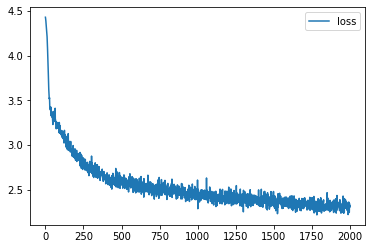

In [8]:
# Your code here
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as a PyTorch module.
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16,
                 rnn_num_units=64):
        super(self.__class__, self).__init__()

        self.num_units = rnn_num_units
        #
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(
            embedding_size + rnn_num_units,
            rnn_num_units
        ) # [embedding_size + rnn_num_units, rnn_num_units]
        # [rnn_num_units, num_tokens]
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next). 
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64 type
        :param h_prev: previous RNN hidden states, containing matrix 
        [batch, rnn_num_units] of float32 type
        """
        # get vector embedding of x
        # [embedding_size]
        x_emb = self.embedding(x) 

        # compute next hidden state using self.rnn_update
        # print(h_prev.size(), x_emb.size())
        # [embedding_size + rnn_num_units, rnn_num_units]
        x_and_h = torch.cat([h_prev, x_emb], dim=-1)
        # print(x_and_h.size())
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        # compute logits for the next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, F.log_softmax(logits, -1)

    def initial_state(self, batch_size):
        """Return RNN state before it processes the first input (h0)."""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


def to_matrix(names, max_len=None, pad=token_to_idx[' '],
              dtype="int32", batch_first=True):
    """Casts a list of names into RNN-digestable matrix."""
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time steps in names_ix.
    :param names_ix: an int32 matrix of shape [batch, time], 
    output of to_matrix(names)
    """
    # print("batch_ix=",batch_ix.shape)
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)

    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        # print("x_t, hid_state = ",x_t.shape, hid_state.shape)
        hid_state, logits_next = char_rnn(x_t, hid_state)  # single step call
        logprobs.append(F.log_softmax(logits_next, -1))
        
    return torch.stack(logprobs, dim=1)

char_rnn = CharRNNCell()
criterion = nn.NLLLoss() 
opt = torch.optim.Adam(char_rnn.parameters())
history = []
MAX_LENGTH = 32
num_tokens = len(tokens)
batch_size = 32

for i in range(2_000):
    start_idxs = np.random.randint(0, len(text) - batch_size, size=batch_size)
    substrings = [text[start_idx:start_idx+batch_size] for start_idx in start_idxs]
    batch_ix = torch.tensor(
        to_matrix(
            substrings, max_len=MAX_LENGTH, pad=token_to_idx[' ']
        ),
        dtype=torch.int64
    )
    logp_seq = rnn_loop(char_rnn, batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )
    loss.backward()
    opt.step()
    opt.zero_grad()
    # if i>20: break
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()
    


Plot the loss function (axis X: number of epochs, axis Y: loss function).

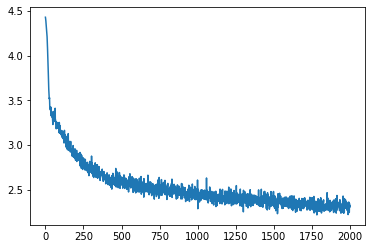

In [9]:
# Your plot code here
plt.plot(history, label="loss")

In [10]:
def generate_text(char_rnn, seed_phrase=' Hello'.lower(), max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = torch.tensor(
        to_matrix(
            [seed_phrase], 
            max_len=MAX_LENGTH, 
            pad=token_to_idx[' ']
        ),
        dtype=torch.int64
    )
    
    # x_sequence = [token_to_idx[token] for token in seed_phrase]
    # x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    print(f"x_sequence={x_sequence.size()} {x_sequence[:, -1].shape}")
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for x in x_sequence.transpose(0, 1):
        # print("x, hid_state = ", x.shape, hid_state.shape)
        hid_state, out = char_rnn(x, hid_state)
        # print("out, hid_state = ", out.shape, hid_state.shape)
    # #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape, x_sequence[:, -1])
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [11]:
# An example of generated text.
# print(generate_text(char_rnn, max_length=500, temperature=0.2))
# temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
# for temperature in temperatures:
#     generated_text = generate_sample(char_lstm, seed_phrase = ' a', temperature = temperature)
#     print ('Text generation with a temperature of', temperature, ':', generated_text)

print(generate_text(char_rnn, seed_phrase='любовь', temperature = 0.6, max_length=500))



x_sequence=torch.Size([1, 32]) torch.Size([1])
любовь                          продьный ледно в сомиль
ужпод и оворый и боный домловить я не слаже в беправали мера в говораный красовестьяний согду в приспишам ведет госта
в голень она богде дри в зам не востет и сних не прирасной дуча.



xxii

как набырать они в блазались бедохло падрастеть
он оней молянной вететней влодамный проскаталенный моль вы стор вимовкой,
как татой,
тетой вжан,
довоть олило безкой пострежный сваренью корго полкой порепет вздих пирной
друг сестала, милени,
в серенью
презда свлисенать ей спрерн


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)